In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from combined_thresh import combined_thresh
from perspective_transform import perspective_transform
from Line import Line
from line_fit import line_fit, tune_fit, final_viz, calc_curve, calc_vehicle_offset
from moviepy.editor import VideoFileClip

In [2]:
#making the moviepy video annotation work
with open('calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
window_size = 5 
left_line = Line(n=window_size)
right_line = Line(n=window_size)
detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0.  # radius of curvature for left and right lanes
left_lane_inds, right_lane_inds = None, None  # for calculating curvature

In [3]:
def annotate_image(img_in):
    global mtx, dist, left_line, right_line, detected
    global left_curve, right_curve, left_lane_inds, right_lane_inds

    #Undistort, threshold, perspective transform
    undist = cv2.undistort(img_in, mtx, dist, None, mtx)
    img, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(undist)
    binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)

    #Perform polynomial fit
    if not detected:
        #slow line fit
        ret = line_fit(binary_warped)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']

        #moving average of line fit coefficients
        left_fit = left_line.add_fit(left_fit)
        right_fit = right_line.add_fit(right_fit)

        #Calculating the curvature
        left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

        detected = True  #the slow line fit always detects the line

    else:  
        #fast line fit
        left_fit = left_line.get_fit()
        right_fit = right_line.get_fit()
        ret = tune_fit(binary_warped, left_fit, right_fit)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']

        #updating only if we detected lines in current frame
        if ret is not None:
            left_fit = ret['left_fit']
            right_fit = ret['right_fit']
            nonzerox = ret['nonzerox']
            nonzeroy = ret['nonzeroy']
            left_lane_inds = ret['left_lane_inds']
            right_lane_inds = ret['right_lane_inds']

            left_fit = left_line.add_fit(left_fit)
            right_fit = right_line.add_fit(right_fit)
            left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
        else:
            detected = False

    vehicle_offset = calc_vehicle_offset(undist, left_fit, right_fit)

    #Perform final visualization on top of original undistorted image
    result = final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)

    return result

In [4]:
def annotate_video(input_file, output_file):
    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(annotate_image)
    annotated_video.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:47<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 



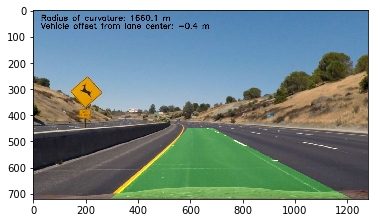

In [5]:
if __name__ == '__main__':
    annotate_video('test_video.mp4', 'test_output.mp4')
    img_file = 'test_images/test2.jpg'
    img = mpimg.imread(img_file)
    result = annotate_image(img)
    result = annotate_image(img)
    result = annotate_image(img)
    plt.imshow(result)
    plt.show()